<a href="https://colab.research.google.com/github/jinnic/ada-project1/blob/main/Unsupervised_Learning_for_case_pridiction_using_PERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install -U scikit-learn==1.4

# **Step 1-1:**  Get Dataset from PERM [2024 PERM data](https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/PERM_Disclosure_Data_New_Form_FY2024_Q4.xlsx)


In [62]:
github_data_url = 'https://raw.githubusercontent.com/jinnic/ada-project1/refs/heads/main/Project%201/raw_case_approve_2024_1.csv'

# Read the CSV file directly from the GitHub URL
df = pd.read_csv(github_data_url)
print("Column names and type")
print(df.info())


Column names and type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22292 entries, 0 to 22291
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CASE_STATUS                     22292 non-null  object 
 1   OCCUPATION_TYPE                 22292 non-null  object 
 2   EMP_NAICS                       22292 non-null  int64  
 3   EMP_NUM_PAYROLL                 22289 non-null  float64
 4   EMP_YEAR_COMMENCED              22292 non-null  int64  
 5   JOB_TITLE                       22226 non-null  object 
 6   JOB_OPP_WAGE_FROM               22226 non-null  object 
 7   JOB_OPP_WAGE_TO                 10898 non-null  object 
 8   JOB_OPP_WAGE_PER                22226 non-null  object 
 9   PRIMARY_WORKSITE_TYPE           22292 non-null  object 
 10  PRIMARY_WORKSITE_CITY           21086 non-null  object 
 11  PRIMARY_WORKSITE_STATE          21086 non-null  object 
 12  PRIMARY_WO

In [63]:
print("Missing data for each column")
print(df.isna().sum())

Missing data for each column
CASE_STATUS                           0
OCCUPATION_TYPE                       0
EMP_NAICS                             0
EMP_NUM_PAYROLL                       3
EMP_YEAR_COMMENCED                    0
JOB_TITLE                            66
JOB_OPP_WAGE_FROM                    66
JOB_OPP_WAGE_TO                   11394
JOB_OPP_WAGE_PER                     66
PRIMARY_WORKSITE_TYPE                 0
PRIMARY_WORKSITE_CITY              1206
PRIMARY_WORKSITE_STATE             1206
PRIMARY_WORKSITE_BLS_AREA          1205
IS_MULTIPLE_LOCATIONS                54
OTHER_REQ_IS_FULLTIME_EMP            54
OTHER_REQ_IS_LIVEIN_HOUSEHOLD        54
OTHER_REQ_JOB_FOREIGN_LANGUAGE        0
dtype: int64


## **Based on [Data dictionary](https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/PERM_New_Form_Record_Layout_FY2025_Q3.pdf):**
* Only keep 'Certified' &
'Denied' for 'CASE_STATUS' as target
* Filter out only yearly wage, fulltime, non livein job


## **Columns to Filter out**

```
'CASE_STATUS' == 'Certified' & 'Denied'
'JOB_OPP_WAGE_PER' == 'Year'
'OTHER_REQ_IS_FULLTIME_EMP' == 'Y'
'OTHER_REQ_IS_LIVEIN_HOUSEHOLD' == 'N'
```



In [64]:
df_filter = df[
    ((df['CASE_STATUS'] == 'Certified') | (df['CASE_STATUS'] == 'Denied')) &
    (df['JOB_OPP_WAGE_PER'] == 'Year') &
    (df['OTHER_REQ_IS_FULLTIME_EMP'] == 'Y') &
    (df['OTHER_REQ_IS_LIVEIN_HOUSEHOLD'] == 'N')
].copy()


print(f"Original row count: {len(df)}")
print(f"Filtered row count: {len(df_filter)}")

print(df_filter.isna().sum())

Original row count: 22292
Filtered row count: 15458
CASE_STATUS                          0
OCCUPATION_TYPE                      0
EMP_NAICS                            0
EMP_NUM_PAYROLL                      0
EMP_YEAR_COMMENCED                   0
JOB_TITLE                            0
JOB_OPP_WAGE_FROM                    0
JOB_OPP_WAGE_TO                   8358
JOB_OPP_WAGE_PER                     0
PRIMARY_WORKSITE_TYPE                0
PRIMARY_WORKSITE_CITY              878
PRIMARY_WORKSITE_STATE             878
PRIMARY_WORKSITE_BLS_AREA          877
IS_MULTIPLE_LOCATIONS                0
OTHER_REQ_IS_FULLTIME_EMP            0
OTHER_REQ_IS_LIVEIN_HOUSEHOLD        0
OTHER_REQ_JOB_FOREIGN_LANGUAGE       0
dtype: int64



# **Step 1-2:** Divide into Training and Testing Sets

In [65]:
from sklearn.model_selection import train_test_split


# 1. Define the final X (Features) and Y (Target)
Y = df_filter['CASE_STATUS']
X = df_filter.drop(columns=['CASE_STATUS'])

# 2. Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    stratify=Y,
    test_size=0.2, # 20% for testing
    random_state=42 # Ensures reproducible
)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (12366, 16), X_test shape: (3092, 16)
y_train shape: (12366,), y_test shape: (3092,)


# **Step 1-3:** Explore training set

In [66]:
# Show the data type of the training features
print("Training Features (X_train) Information:")
X_train.info()

# Show the summary of the target variable (wage)
print("\nTarget (y_train) Summary:")
print(y_train.describe())

Training Features (X_train) Information:
<class 'pandas.core.frame.DataFrame'>
Index: 12366 entries, 9304 to 7443
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   OCCUPATION_TYPE                 12366 non-null  object 
 1   EMP_NAICS                       12366 non-null  int64  
 2   EMP_NUM_PAYROLL                 12366 non-null  float64
 3   EMP_YEAR_COMMENCED              12366 non-null  int64  
 4   JOB_TITLE                       12366 non-null  object 
 5   JOB_OPP_WAGE_FROM               12366 non-null  object 
 6   JOB_OPP_WAGE_TO                 5684 non-null   object 
 7   JOB_OPP_WAGE_PER                12366 non-null  object 
 8   PRIMARY_WORKSITE_TYPE           12366 non-null  object 
 9   PRIMARY_WORKSITE_CITY           11654 non-null  object 
 10  PRIMARY_WORKSITE_STATE          11654 non-null  object 
 11  PRIMARY_WORKSITE_BLS_AREA       11655 non-null  object 

In [67]:
print(X_train.isna().sum())

OCCUPATION_TYPE                      0
EMP_NAICS                            0
EMP_NUM_PAYROLL                      0
EMP_YEAR_COMMENCED                   0
JOB_TITLE                            0
JOB_OPP_WAGE_FROM                    0
JOB_OPP_WAGE_TO                   6682
JOB_OPP_WAGE_PER                     0
PRIMARY_WORKSITE_TYPE                0
PRIMARY_WORKSITE_CITY              712
PRIMARY_WORKSITE_STATE             712
PRIMARY_WORKSITE_BLS_AREA          711
IS_MULTIPLE_LOCATIONS                0
OTHER_REQ_IS_FULLTIME_EMP            0
OTHER_REQ_IS_LIVEIN_HOUSEHOLD        0
OTHER_REQ_JOB_FOREIGN_LANGUAGE       0
dtype: int64


In [68]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print("Categorical features:")
print(categorical_features)

print("\nNumerical features:")
print(numerical_features)


Categorical features:
['OCCUPATION_TYPE', 'JOB_TITLE', 'JOB_OPP_WAGE_FROM', 'JOB_OPP_WAGE_TO', 'JOB_OPP_WAGE_PER', 'PRIMARY_WORKSITE_TYPE', 'PRIMARY_WORKSITE_CITY', 'PRIMARY_WORKSITE_STATE', 'PRIMARY_WORKSITE_BLS_AREA', 'IS_MULTIPLE_LOCATIONS', 'OTHER_REQ_IS_FULLTIME_EMP', 'OTHER_REQ_IS_LIVEIN_HOUSEHOLD', 'OTHER_REQ_JOB_FOREIGN_LANGUAGE']

Numerical features:
['EMP_NAICS', 'EMP_NUM_PAYROLL', 'EMP_YEAR_COMMENCED']


# **Step 1-4: Data cleaning**

1.  **Impute missing BLS_Area data: I am deciding to drop them rather then adding mode value becuase of broad range**
2.   **Create Avg wage feature with 'JOB_OPP_WAGE_FROM' &	'JOB_OPP_WAGE_TO'**
3. **Simplify NAICS code to first two digit**



## **✅ 1. Fill missing BLS_Area with mode of Train data**

```
'PRIMARY_WORKSITE_BLS_AREA'
```




In [69]:
# 1. Calculate the mode from the training data (X_train)
mode_val_train = X_train['PRIMARY_WORKSITE_BLS_AREA'].mode()[0]

# 2. Impute X_train (Recommended Non-Inplace Assignment)
X_train['PRIMARY_WORKSITE_BLS_AREA'] = X_train['PRIMARY_WORKSITE_BLS_AREA'].fillna(mode_val_train)

# 3. Impute X_test (CRITICAL: Use X_train's mode to prevent data leakage)
X_test['PRIMARY_WORKSITE_BLS_AREA'] = X_test['PRIMARY_WORKSITE_BLS_AREA'].fillna(mode_val_train)

# Note: The original code used X_test's mode for X_test, which is a form of data leakage.
# The correction above uses mode_val_train for both, which is the standard practice.

print("Missing values in PRIMARY_WORKSITE_BLS_AREA have been imputed.")
print(f"X_train missing count: {X_train['PRIMARY_WORKSITE_BLS_AREA'].isna().sum()}")
print(f"X_test missing count: {X_test['PRIMARY_WORKSITE_BLS_AREA'].isna().sum()}")

Missing values in PRIMARY_WORKSITE_BLS_AREA have been imputed.
X_train missing count: 0
X_test missing count: 0


## **✅ 2. Create Average wage colum**

```
'JOB_AVG_WAGE' is not empty # calculated with 'JOB_OPP_WAGE_FROM' &
'JOB_OPP_WAGE_TO'
```




In [70]:
# Convert relevant columns to numeric, stripping non-numeric characters
for col in ['JOB_OPP_WAGE_FROM', 'JOB_OPP_WAGE_TO']:
    X_train[col] = X_train[col].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

# If 'JOB_OPP_WAGE_TO' is empty, replace it with 'JOB_OPP_WAGE_FROM'
X_train['JOB_OPP_WAGE_TO'] = X_train['JOB_OPP_WAGE_TO'].fillna(X_train['JOB_OPP_WAGE_FROM'])
# Create 'JOB_AVG_WAGE' by averaging the two columns
X_train['JOB_AVG_WAGE'] = (X_train['JOB_OPP_WAGE_FROM'] + X_train['JOB_OPP_WAGE_TO']) / 2

# Drop null row of 'JOB_AVG_WAGE'
print(f"Original row count: {len(X_train)}")

print(X_train.isna().sum())

# Check calculation
print(X_train['JOB_AVG_WAGE'].dtype)
display(X_train[['JOB_OPP_WAGE_FROM', 'JOB_OPP_WAGE_TO', 'JOB_AVG_WAGE']].head(10))




Original row count: 12366
OCCUPATION_TYPE                     0
EMP_NAICS                           0
EMP_NUM_PAYROLL                     0
EMP_YEAR_COMMENCED                  0
JOB_TITLE                           0
JOB_OPP_WAGE_FROM                   0
JOB_OPP_WAGE_TO                     0
JOB_OPP_WAGE_PER                    0
PRIMARY_WORKSITE_TYPE               0
PRIMARY_WORKSITE_CITY             712
PRIMARY_WORKSITE_STATE            712
PRIMARY_WORKSITE_BLS_AREA           0
IS_MULTIPLE_LOCATIONS               0
OTHER_REQ_IS_FULLTIME_EMP           0
OTHER_REQ_IS_LIVEIN_HOUSEHOLD       0
OTHER_REQ_JOB_FOREIGN_LANGUAGE      0
JOB_AVG_WAGE                        0
dtype: int64
float64


JOB_OPP_WAGE_FROM  JOB_OPP_WAGE_TO  JOB_AVG_WAGE
9304             33904.0          33904.0       33904.0
12687            34029.0          45760.0       39894.5
15837            35880.0          35880.0       35880.0
13680           120058.0         142300.0      131179.0
10665           111538.0         153200.0      132369.0
5800             53040.0          53040.0       53040.0
21394            30160.0          30160.0       30160.0
13898            27144.0          27144.0       27144.0
15349            26749.0          26749.0       26749.0
18251           127920.0         237600.0      182760.0

### **🔁 Do the same to Test set**

In [71]:
# Convert relevant columns to numeric, stripping non-numeric characters
for col in ['JOB_OPP_WAGE_FROM', 'JOB_OPP_WAGE_TO']:
    X_test[col] = X_test[col].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# If 'JOB_OPP_WAGE_TO' is empty, replace it with 'JOB_OPP_WAGE_FROM'
X_test['JOB_OPP_WAGE_TO'] = X_test['JOB_OPP_WAGE_TO'].fillna(X_test['JOB_OPP_WAGE_FROM'])
# Create 'JOB_AVG_WAGE' by averaging the two columns
X_test['JOB_AVG_WAGE'] = (X_test['JOB_OPP_WAGE_FROM'] + X_test['JOB_OPP_WAGE_TO']) / 2


##✅ **3-1. Create join table for NAICS with Industry name**

In [72]:
naics_data = """
11	Agriculture, Forestry, Fishing and Hunting
21	Mining, Quarrying, and Oil and Gas Extraction
22	Utilities
23	Construction
31-33	Manufacturing
42	Wholesale Trade
44-45	Retail Trade
48-49	Transportation and Warehousing
51	Information
52	Finance and Insurance
53	Real Estate and Rental and Leasing
54	Professional, Scientific, and Technical Services
55	Management of Companies and Enterprises
56	Administrative and Support and Waste Management and Remediation Services
61	Educational Services
62	Health Care and Social Assistance
71	Arts, Entertainment, and Recreation
72	Accommodation and Food Services
81	Other Services (except Public Administration)
92	Public Administration
"""

naics_mapping = {}
for line in naics_data.strip().split('\n'):
    parts = line.split('\t')
    code_str = parts[0]
    sector_name = parts[1]

    if '-' in code_str:
        start, end = map(int, code_str.split('-'))
        for i in range(start, end + 1):
            naics_mapping[str(i)] = sector_name
    else:
        naics_mapping[code_str] = sector_name

# Create a DataFrame from the mapping
naics_df = pd.DataFrame(naics_mapping.items(), columns=['NAICS_CODE', 'NAICS_DESCRIPTION'])

print("NAICS CODE Mapping DataFrame:")
display(naics_df.head(10))
print(f"Total unique NAICS CODES: {len(naics_df)}")
print(f"Total unique NAICS DESCRIPTIONS: {naics_df['NAICS_DESCRIPTION'].nunique()}")


NAICS CODE Mapping DataFrame:


NAICS_CODE                              NAICS_DESCRIPTION
0         11     Agriculture, Forestry, Fishing and Hunting
1         21  Mining, Quarrying, and Oil and Gas Extraction
2         22                                      Utilities
3         23                                   Construction
4         31                                  Manufacturing
5         32                                  Manufacturing
6         33                                  Manufacturing
7         42                                Wholesale Trade
8         44                                   Retail Trade
9         45                                   Retail Trade

Total unique NAICS CODES: 24
Total unique NAICS DESCRIPTIONS: 20


## **✅ 3-2. Simplyfy NAICS - North American Industry Classification System**

Keep first two digit for simpler category of industry

In [73]:
# Convert the EMP_NAICS column to a string
# slice to keep first two digit
X_train['NAICS_CODE'] = X_train['EMP_NAICS'].astype(str).str[0:2]

# Check its unique values and count to make sure it's matching join table
print(sorted(X_train['NAICS_CODE'].unique()))
print(f"Total unique NAICS codes mapped: {len(X_train['NAICS_CODE'].unique())}")

display(X_train[['EMP_NAICS', 'NAICS_CODE']].head())

['11', '21', '22', '23', '31', '32', '33', '42', '44', '45', '48', '49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '92']
Total unique NAICS codes mapped: 24


EMP_NAICS NAICS_CODE
9304       56173         56
12687     722511         72
15837     336111         33
13680     515210         51
10665      51821         51

In [74]:
# Merge X_train with naics_df to add the NAICS_DESCRIPTION
X_train = pd.merge(
    X_train,
    naics_df,
    left_on='NAICS_CODE',
    right_on='NAICS_CODE', # Use NAICS_CODE from naics_df
    how='left'
)

# Display the first few rows to show the new 'NAICS_DESCRIPTION' column
display(X_train[['EMP_NAICS', 'NAICS_CODE', 'NAICS_DESCRIPTION']].head())
print(f"Total unique NAICS DESCRIPTIONS: {X_train['NAICS_DESCRIPTION'].nunique()}")

# Check for any missing values in the new 'NAICS_DESCRIPTION' column
print(f"Missing values in NAICS_DESCRIPTION in X_train after merge: {X_train['NAICS_DESCRIPTION'].isnull().sum()}")

EMP_NAICS NAICS_CODE                                  NAICS_DESCRIPTION
0      56173         56  Administrative and Support and Waste Managemen...
1     722511         72                    Accommodation and Food Services
2     336111         33                                      Manufacturing
3     515210         51                                        Information
4      51821         51                                        Information

Total unique NAICS DESCRIPTIONS: 20
Missing values in NAICS_DESCRIPTION in X_train after merge: 0


### **🔁 Do the same to Test set**

In [75]:
# Convert the EMP_NAICS column to a string
# slice to keep first two digit
X_test['NAICS_CODE'] = X_test['EMP_NAICS'].astype(str).str[0:2]
# Merge X_test with naics_df to add the NAICS_DESCRIPTION
X_test = pd.merge(
    X_test,
    naics_df,
    left_on='NAICS_CODE',
    right_on='NAICS_CODE', # Use NAICS_CODE from naics_df
    how='left'
)

# Check for any missing values in the new 'NAICS_DESCRIPTION' column
print(f"Missing values in NAICS_DESCRIPTION in X_test after merge: {X_test['NAICS_DESCRIPTION'].isnull().sum()}")

Missing values in NAICS_DESCRIPTION in X_test after merge: 0


## **✅4. Clean Job title**
* Merge jr and junior, sr and senior

In [76]:
# Convert to lowercase and remove leading/trailing spaces
X_train['JOB_TITLE_CLEAN'] = X_train['JOB_TITLE'].str.lower().str.strip()
print(f"Unique Titles before cleaning: {X_train['JOB_TITLE'].nunique()}")

# remove common seniority prefixes/suffixes and numbers from title
X_train['JOB_TITLE_CLEAN'] = (
    X_train['JOB_TITLE_CLEAN']
    .str.replace(r'\b(sr|senior)\b', 'sr.', regex=True)
    .str.replace(r'\b(jr|junior)\b', 'jr.', regex=True)
    .str.replace(r'[^\w\s]', '', regex=True) # Remove punctuation (e.g., commas, dashes)
    .str.replace(r'\s+', ' ', regex=True)     # Collapse multiple spaces into one
    .str.strip()
)



print(f"Unique Titles after cleaning: {X_train['JOB_TITLE_CLEAN'].nunique()}")

Unique Titles before cleaning: 4676
Unique Titles after cleaning: 4127


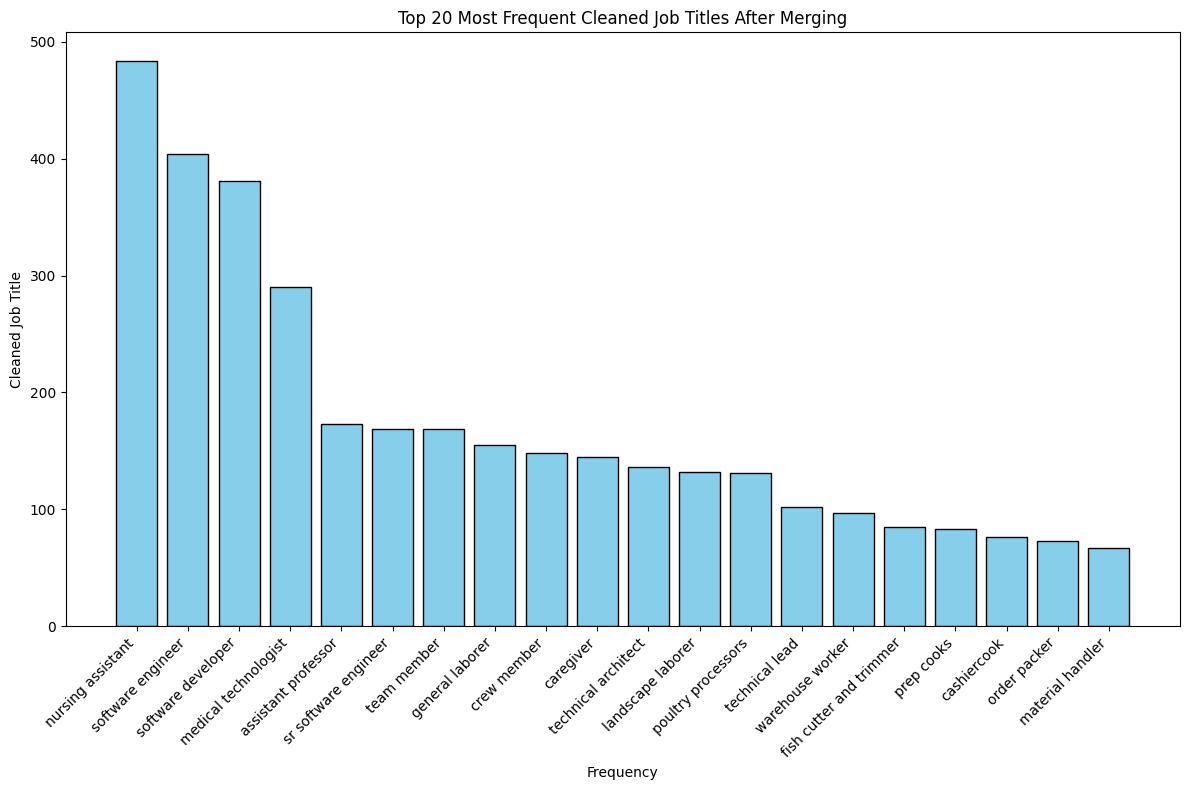

In [77]:
# Get the top 20 cleaned job titles
top_n = 20
top_job_titles = X_train['JOB_TITLE_CLEAN'].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 8))
plt.bar(top_job_titles.index, top_job_titles.values, edgecolor='black', color='skyblue')
plt.title(f'Top {top_n} Most Frequent Cleaned Job Titles After Merging')
plt.xlabel('Frequency')
plt.ylabel('Cleaned Job Title')
plt.xticks(rotation=45, ha='right') # Rotate labels
plt.tight_layout()
plt.show()

### **🔁 Do the same to Test set**

In [78]:
# Convert to lowercase and remove leading/trailing spaces
X_test['JOB_TITLE_CLEAN'] = X_test['JOB_TITLE'].str.lower().str.strip()

# remove common seniority prefixes/suffixes and numbers from title
X_test['JOB_TITLE_CLEAN'] = (
    X_test['JOB_TITLE_CLEAN']
    .str.replace(r'\b(sr|senior)\b', 'sr.', regex=True)
    .str.replace(r'\b(jr|junior)\b', 'jr.', regex=True)
    .str.replace(r'[^\w\s]', '', regex=True) # Remove punctuation (e.g., commas, dashes)
    .str.replace(r'\s+', ' ', regex=True)     # Collapse multiple spaces into one
    .str.strip()
)


## ✅ **5. Company Size & Tenure**
Define the boundaries for company size categories and calculate the age of the company based on the year the dataset was published (Fiscal Year 2024)



### **5-1.Thresholds common in business/economic:**

* Small: < 50 employees
* Mid: 50 to 1,000 employees
* Large: > 1,000 employees



```
bins = [0, 50, 1000, np.inf]
labels = ['Small', 'Mid', 'Large']
```

In [79]:
# Check for values less than or equal to 0
print(f"Count of EMP_NUM_PAYROLL <= 0: {(X_train['EMP_NUM_PAYROLL'] <=0).sum()}")

# Check for non-finite values (inf, -inf) which are not normal NaNs
print(f"Count of non-finite values: {np.sum(~np.isfinite(X_train['EMP_NUM_PAYROLL']))}")

Count of EMP_NUM_PAYROLL <= 0: 61
Count of non-finite values: 0


In [80]:
bins = [-1, 50, 1000, np.inf] # to include 0 I put -1
labels = ['Small', 'Mid', 'Large']

X_train['COMPANY_SIZE_CAT'] = pd.cut(
    X_train['EMP_NUM_PAYROLL'],
    bins=bins,
    labels=labels
)

print("\nCompany Size Distribution:")
print(X_train['COMPANY_SIZE_CAT'].value_counts(dropna=False))


X_test['COMPANY_SIZE_CAT'] = pd.cut(
    X_test['EMP_NUM_PAYROLL'],
    bins=bins,
    labels=labels
)



Company Size Distribution:
COMPANY_SIZE_CAT
Mid      5240
Small    3585
Large    3541
Name: count, dtype: int64


### **5-2. Create 'COMPANY_AGE' column**

In [81]:
REFERENCE_YEAR = 2024

# Convert 0 in EMP_YEAR_COMMENCED to NaN for both DataFrames
X_train['EMP_YEAR_COMMENCED'] = X_train['EMP_YEAR_COMMENCED'].replace(0, np.nan)
X_test['EMP_YEAR_COMMENCED'] = X_test['EMP_YEAR_COMMENCED'].replace(0, np.nan)

# Calculate company age in years
X_train['COMPANY_AGE'] = REFERENCE_YEAR - X_train['EMP_YEAR_COMMENCED']
X_test['COMPANY_AGE'] = REFERENCE_YEAR - X_test['EMP_YEAR_COMMENCED']

# Calculate the median of COMPANY_AGE from X_train
median_age_train = X_train['COMPANY_AGE'].median()

# 4. Impute NaNs in COMPANY_AGE for both X_train and X_test using the median from X_train
X_train['COMPANY_AGE'] = X_train['COMPANY_AGE'].fillna(median_age_train)
X_test['COMPANY_AGE'] = X_test['COMPANY_AGE'].fillna(median_age_train)

print("\nCompany Age (Length of Establishment) Statistics:")
print(X_train['COMPANY_AGE'].describe())


Company Age (Length of Establishment) Statistics:
count    12366.000000
mean        37.269772
std         41.480468
min          1.000000
25%         12.000000
50%         23.000000
75%         47.000000
max        374.000000
Name: COMPANY_AGE, dtype: float64


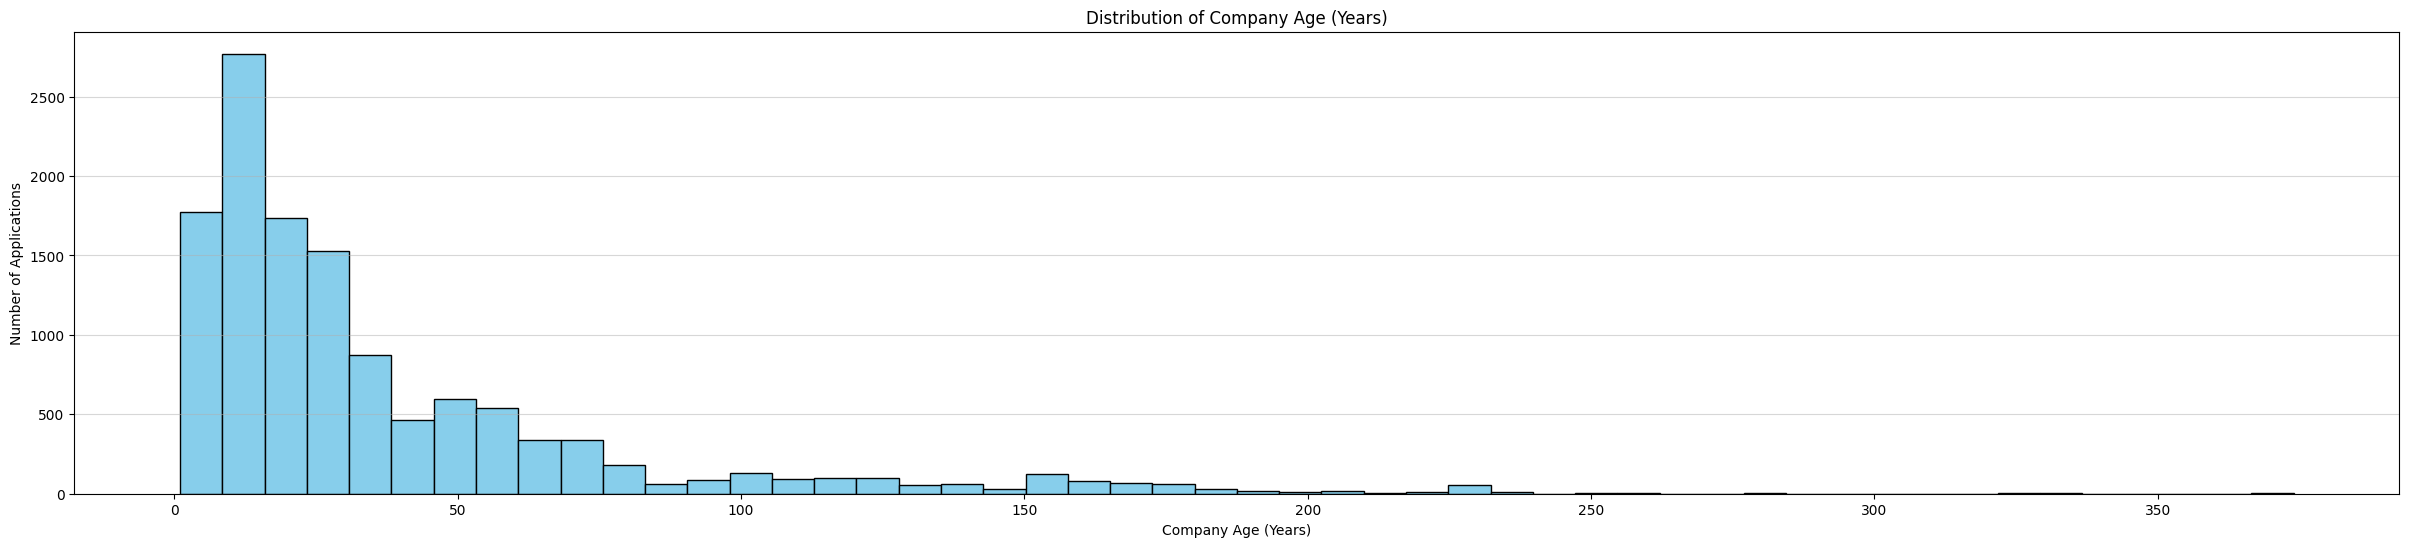

In [82]:
import matplotlib.pyplot as plt

# 1. Set the size of the plot
plt.figure(figsize=(30, 6))

# 2. Create the histogram
plt.hist(X_train['COMPANY_AGE'], bins=50, edgecolor='black', color='skyblue')

# 3. Add labels and a title for clarity
plt.title('Distribution of Company Age (Years)')
plt.xlabel('Company Age (Years)')
plt.ylabel('Number of Applications')
plt.grid(axis='y', alpha=0.5)

# 4. Show the plot
plt.show()

### **5-3. Thresholds for company age based on distribution:**

* Young: < 10 years old
* Established: 10 to 25 years old
* Mature: 25 to 45 years old
* Legacy: > 45 years old



```
bins = [0, 10, 25, 45, np.inf]
labels = ['Young', 'Established', 'Mature', 'Legacy']
```


In [83]:
bins = [-1, 10, 25, 45, np.inf]
labels = ['Young', 'Established', 'Mature', 'Legacy']

# Create the new categorical column
X_train['COMPANY_AGE_CAT'] = pd.cut(
    X_train['COMPANY_AGE'],
    bins=bins,
    labels=labels
)

X_test['COMPANY_AGE_CAT'] = pd.cut(
    X_test['COMPANY_AGE'],
    bins=bins,
    labels=labels
)

# Display the new distribution
print("\nCompany Age Category Distribution (Custom Bins):")
print(X_train['COMPANY_AGE_CAT'].value_counts())


Company Age Category Distribution (Custom Bins):
COMPANY_AGE_CAT
Established    4290
Legacy         3225
Young          2458
Mature         2393
Name: count, dtype: int64


## ✅ **6. Visualize BLS area distribution**


BLS Area categories (X_train): 403


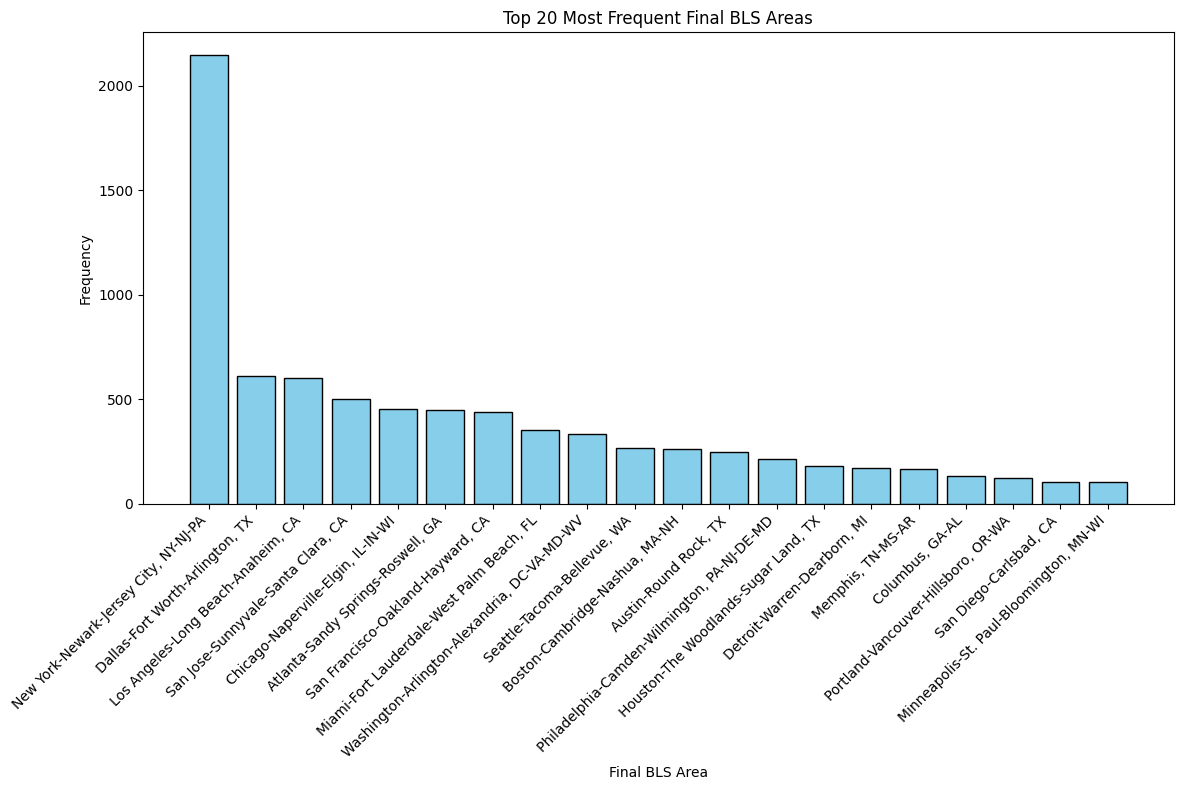

In [84]:
print(f"BLS Area categories (X_train): {X_train['PRIMARY_WORKSITE_BLS_AREA'].nunique()}")

# Get the top 20 most frequent final BLS areas
top_n = 20
top_bls_areas = X_train['PRIMARY_WORKSITE_BLS_AREA'].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 8))
plt.bar(top_bls_areas.index, top_bls_areas.values, edgecolor='black', color='skyblue')
plt.title(f'Top {top_n} Most Frequent Final BLS Areas')
plt.xlabel('Final BLS Area')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## ✅ **7. Drop unneccesry columns**
Columns that are filtered or used to create feature.

* 'JOB_OPP_WAGE_TO' & 'JOB_OPP_WAGE_FROM'
* 'JOB_OPP_WAGE_PER' == 'Year'
* 'OTHER_REQ_IS_FULLTIME_EMP' == 'Y'
* 'OTHER_REQ_IS_LIVEIN_HOUSEHOLD' == 'N'



In [85]:
columns_to_drop = [
    'JOB_OPP_WAGE_FROM',
    'JOB_OPP_WAGE_TO',
    'EMP_NAICS',
    'NAICS_CODE',
    'EMP_YEAR_COMMENCED',
    'JOB_TITLE',
    'JOB_TITLE_CLEAN',  #Dropping due to high unique values
    'JOB_OPP_WAGE_PER',
    'PRIMARY_WORKSITE_TYPE',  # Not used
    'PRIMARY_WORKSITE_CITY',  # Redundant/Not used
    'PRIMARY_WORKSITE_STATE', # Redundant/Not used
    'OCCUPATION_TYPE',  # Not used
    'IS_MULTIPLE_LOCATIONS',  # Not used
    'OTHER_REQ_IS_FULLTIME_EMP', # Constant value after filtering
    'OTHER_REQ_IS_LIVEIN_HOUSEHOLD', # Constant value after filtering
    'OTHER_REQ_JOB_FOREIGN_LANGUAGE' # Not used
]
print("Columns dropped successfully.")
print(f"Clean row count: {len(X_train)}")
X_train = X_train.drop(columns=columns_to_drop)
print(f"Final row count: {len(X_train)}")

display(X_train.head())
print("Missing values (NA count) per column:")
print(X_train.isna().sum())

X_test = X_test.drop(columns=columns_to_drop)


Columns dropped successfully.
Clean row count: 12366
Final row count: 12366


EMP_NUM_PAYROLL                PRIMARY_WORKSITE_BLS_AREA  JOB_AVG_WAGE  \
0             34.0          Dallas-Fort Worth-Arlington, TX       33904.0   
1             10.0  Western Washington nonmetropolitan area       39894.5   
2            343.0                              Reading, PA       35880.0   
3           6483.0        Charlotte-Concord-Gastonia, NC-SC      131179.0   
4           1052.0        Atlanta-Sandy Springs-Roswell, GA      132369.0   

                                   NAICS_DESCRIPTION COMPANY_SIZE_CAT  \
0  Administrative and Support and Waste Managemen...            Small   
1                    Accommodation and Food Services            Small   
2                                      Manufacturing              Mid   
3                                        Information            Large   
4                                        Information            Large   

   COMPANY_AGE COMPANY_AGE_CAT  
0         40.0          Mature  
1         38.0          Mature  
2         72.0          Legacy  
3         31.0          Mature  
4         63.0          Legacy

Missing values (NA count) per column:
EMP_NUM_PAYROLL              0
PRIMARY_WORKSITE_BLS_AREA    0
JOB_AVG_WAGE                 0
NAICS_DESCRIPTION            0
COMPANY_SIZE_CAT             0
COMPANY_AGE                  0
COMPANY_AGE_CAT              0
dtype: int64


# **Step 2: Prepare Features**

1. **OrdinalEncoder: 'COMPANY_SIZE_CAT', 'COMPANY_AGE_CAT'**
2. **StandardScaler(numerical data):'JOB_AVG_WAGE', 'COMPANY_AGE'**
3. **OneHotEncode(categorical data): 'PRIMARY_WORKSITE_BLS_AREA', 'NAICS_DESCRIPTION'**



In [86]:
##OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder

# Define the order of the categories
size_categories = ['Small', 'Mid', 'Large']
age_categories = ['Young', 'Established', 'Mature', 'Legacy']

# Create the encoder, specifying the categories for each column
ordinal_encoder = OrdinalEncoder(categories=[size_categories, age_categories],
                                 handle_unknown='error', # Ensures safety if unexpected value appears
                                 dtype=np.int64)

# Define the columns to be transformed
ordinal_cols = ['COMPANY_SIZE_CAT', 'COMPANY_AGE_CAT']

In [87]:
# Fit the encoder only on X_train
ordinal_encoder.fit(X_train[ordinal_cols])

# Apply the transformation to both X_train and X_test
X_train[ordinal_cols] = ordinal_encoder.transform(X_train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

# Check the results
print("Ordinal Encoding .")
print(X_train[ordinal_cols].head())
print("\nData Types:")
print(X_train[ordinal_cols].dtypes)

Ordinal Encoding .
   COMPANY_SIZE_CAT  COMPANY_AGE_CAT
0                 0                2
1                 0                2
2                 1                3
3                 2                2
4                 2                3

Data Types:
COMPANY_SIZE_CAT    int64
COMPANY_AGE_CAT     int64
dtype: object


In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Features to be scaled (numerical with wide range)
numerical_cols = ['JOB_AVG_WAGE', 'COMPANY_AGE']

# Features for One-Hot Encoding (no order)
# 'PRIMARY_WORKSITE_BLS_AREA' has 403 unique values; 'NAICS_DESCRIPTION' has 20 unique values.
onehot_cols = ['PRIMARY_WORKSITE_BLS_AREA', 'NAICS_DESCRIPTION']


In [89]:
## Scaler for numerical columns
numerical_transformer = StandardScaler()

## One-Hot Encoder for categorical columns
# handle_unknown='ignore' ensures that if the test set has a category not seen
# in the train set, it just ignores it (sets all new binary columns to 0) instead of throwing an error.
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [90]:
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, onehot_cols)
    ],
    remainder='passthrough'
)

In [91]:
# Fit the transformer ONLY on the training data (X_train)
preprocessor.fit(X_train)

# Transform both X_train and X_test
X_train_final = preprocessor.transform(X_train)
X_test_final = preprocessor.transform(X_test)

# Convert the resulting NumPy arrays back to DataFrames for easier viewing and model use
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_final, columns=feature_names)
X_test_df = pd.DataFrame(X_test_final, columns=feature_names)


print(f"Original X_train shape: {X_train.shape}")
print(f"Processed X_train_final shape: {X_train_final.shape}")

Original X_train shape: (12366, 7)
Processed X_train_final shape: (12366, 428)


# **PCA (95% variance)**


In [92]:

# import PCA library
from sklearn.decomposition import PCA

# instantiate an instance of PCA with 95%
pca = PCA(n_components=0.95)

# fit on and transforming the training set and then transform the test set
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)

X_train_pca_df = pca.fit_transform(X_train_df)
X_test_pca_df = pca.transform(X_test_df)


# **PCA on supervised learning**

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define the default Logistic Regression model
log_reg_pca = LogisticRegression(
    random_state=42,
    max_iter=2000,
    class_weight='balanced'
)

# Cross-Validationn on the PCA Training Data  (on X_train_pca and y_train)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    log_reg_pca,
    X_train_pca,
    y_train,
    cv=skf,
    scoring='f1_macro',
)

print(f"PCA-Log Reg Cross-Validation F1-macro Scores: {cv_scores}")
print(f"PCA-Log Reg Mean Cross-Validation F1-macro Score: {np.mean(cv_scores):.4f}\n")

# Fit the model and Evaluate on the PCA Test Set
log_reg_pca.fit(X_train_pca, y_train)
y_pred_pca = log_reg_pca.predict(X_test_pca)

print("Default Logistic Regression on PCA Data Evaluation:")
print("---------------------------------------------------------------")
print(classification_report(y_test, y_pred_pca, zero_division=0))

PCA-Log Reg Cross-Validation F1-macro Scores: [0.25261448 0.24532686 0.22473495 0.24449849 0.25789251]
PCA-Log Reg Mean Cross-Validation F1-macro Score: 0.2450

Default Logistic Regression on PCA Data Evaluation:
---------------------------------------------------------------
              precision    recall  f1-score   support

   Certified       1.00      0.29      0.45      3066
      Denied       0.01      0.92      0.02        26

    accuracy                           0.29      3092
   macro avg       0.50      0.61      0.24      3092
weighted avg       0.99      0.29      0.45      3092



The f1-macro score is quite low (around 0.245), which shows that the PCA-based Logistic Regression model struggles to perform well across both classes. The cross-validation scores are consistently low, meaning the model behaves in a stable way but is consistently weak rather than just occasionally failing. This suggests that the model isn't well suited to the extreme class imbalance in the data, especially for identifying the minority “Denied” cases, and is unlikely to generalize well without using imbalance-aware techniques or a different model altogether.

| Metric     | Certified (Majority) | Denied (Minority) | Macro Avg |
|------------|----------------------|-------------------|-----------|
| Precision  | 1.00                 | 0.01              | 0.50      |
| Recall     | 0.29                 | 0.92              | 0.61      |
| F1-Score   | 0.45                 | 0.02              | 0.24      |


# k-Means




In [94]:
# import library
from sklearn.cluster import KMeans


In [95]:
!pip install mglearn
import mglearn

## **k-Means on Original**
:

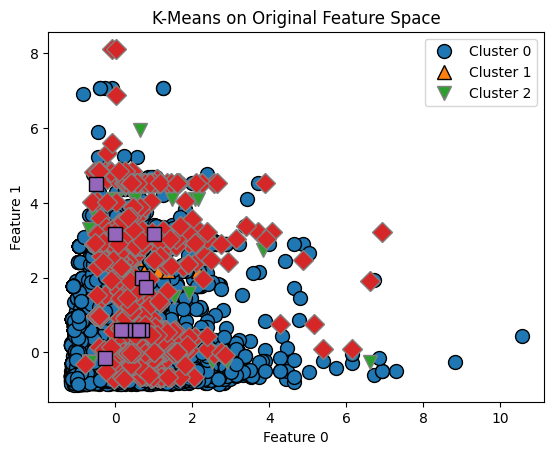

In [96]:
kmeans_orig = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_orig.fit(X_train_final)

assignments=kmeans_orig.labels_
mglearn.discrete_scatter(
    X_train_final[:, 0],
    X_train_final[:, 1],
    assignments
)
plt.title("K-Means on Original Feature Space")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.show()




## **k-Means on PCS**

In [97]:
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_pca.fit(X_train_pca)

# assignments=kmeans_pca.labels_
# mglearn.discrete_scatter(
#     X_train_pca[:, 0],
#     X_train_pca[:, 1],
#     assignments
# )
# plt.title("K-Means on PCA 95%")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
# plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

### 👀 Because **`X_train_pca`** only has 1 column - 1 principal component already explains 100% of the variance. So for assigment purpose, I used 2D PCA rather then 95% for plotting

```
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
/tmp/ipython-input-4122076382.py in <cell line: 0>()
      5 mglearn.discrete_scatter(
      6     X_train_pca[:, 0],
----> 7     X_train_pca[:, 1],
      8     assignments
      9 )

IndexError: index 1 is out of bounds for axis 1 with size 1
```



In [98]:
print("X_train_final shape:", X_train_final.shape)
print("X_train_pca shape:", X_train_pca.shape)
print("n_components_:", pca.n_components_)
print("explained variance sum:", pca.explained_variance_ratio_.sum())


X_train_final shape: (12366, 428)
X_train_pca shape: (12366, 1)
n_components_: 1
explained variance sum: 0.9999999827769617


### **PCA (2 component)**


In [99]:
pca_2 = PCA(n_components=2)
X_train_pca2 = pca_2.fit_transform(X_train_final)


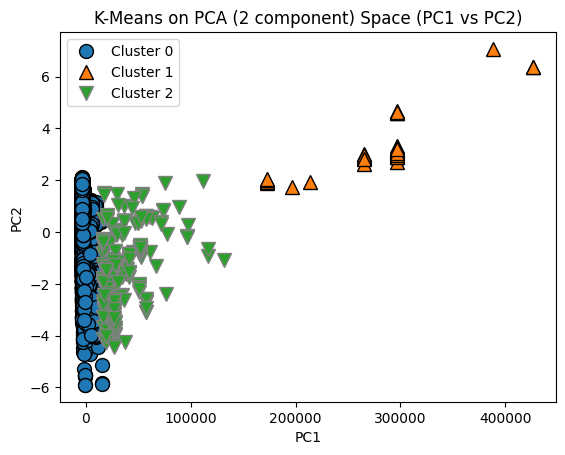

In [100]:
# 2D PCA ONLY for visualization
kmeans_pca_2 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_pca_2.fit(X_train_pca2)


assignments=kmeans_pca_2.labels_
mglearn.discrete_scatter(
    X_train_pca2[:, 0],
    X_train_pca2[:, 1],
    assignments
)
plt.title("K-Means on PCA (2 component) Space (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.show()


# **k-Means elbow visualization**


##**Original data**

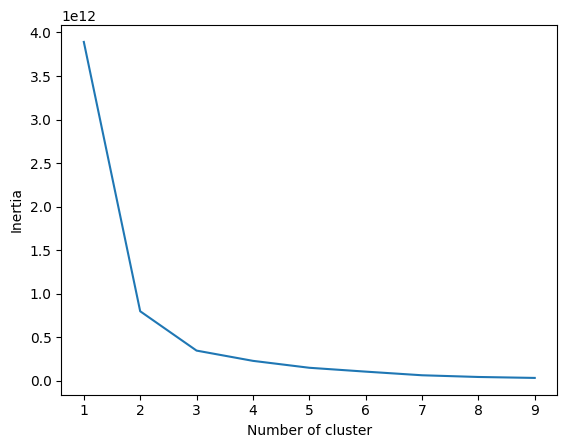

In [101]:

# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000, random_state=42, n_init=10).fit(X_train_final)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

##**PCA data**

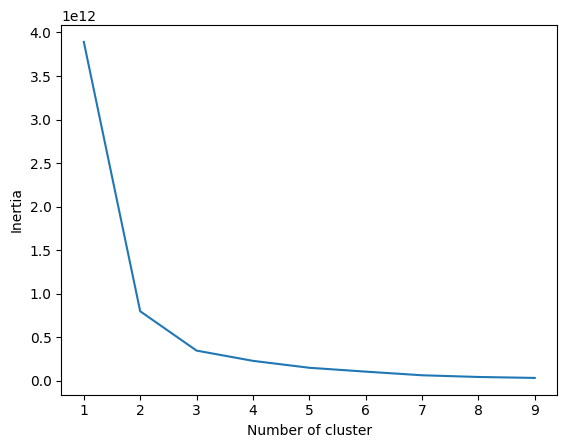

In [102]:

# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000, random_state=42, n_init=10).fit(X_train_pca2)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

The curves for K-Means on the original feature space and the PCA(95%) space are nearly identical. This is because PCA reduced the data to a single dominant principal component that already captures most of the variance. As a result, K-Means operates on very similar distance structures in both cases, leading to comparable values across different numbers of clusters.

# **Aggolmerative/Hierarchical**

In [103]:
from sklearn.cluster import AgglomerativeClustering


Text(0, 0.5, 'Feature 1')

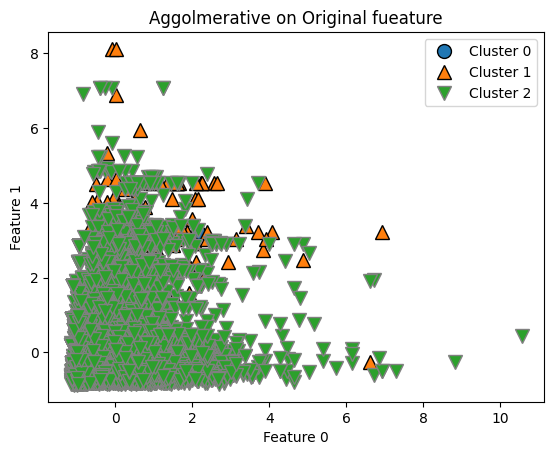

In [104]:

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_train_final)

mglearn.discrete_scatter(X_train_final[:, 0], X_train_final[:, 1], assignment)
plt.title("Aggolmerative on Original fueature")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'PC2')

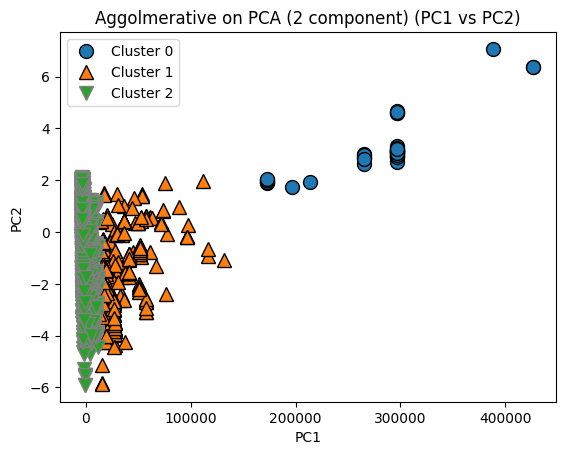

In [105]:

agg_pca = AgglomerativeClustering(n_clusters=3)
assignment = agg_pca.fit_predict(X_train_pca2)

mglearn.discrete_scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], assignment)
plt.title("Aggolmerative on PCA (2 component) (PC1 vs PC2)")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'Cluster distance')

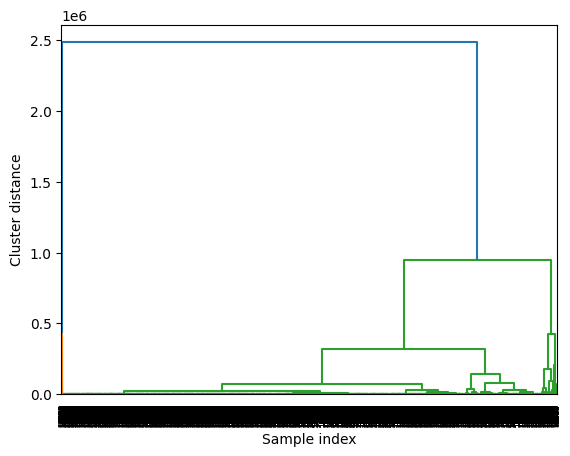

In [106]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X_train_final)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

# **DBSCAN**

In [107]:
from sklearn.cluster import DBSCAN


##**Original data**

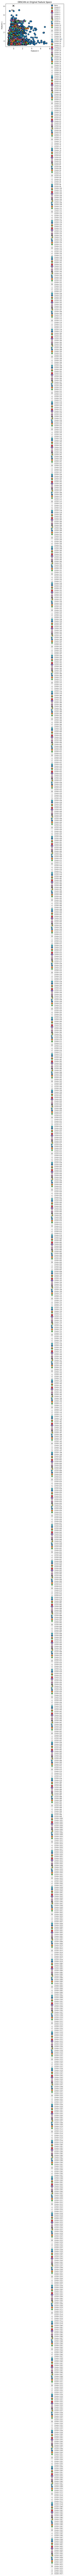

In [108]:
dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(X_train_final)

unique = np.unique(clusters)
markers = ['o','^','v','s','D','*','P','X','<','>','h','H','p','+','x','1','2','3','4','8']
# repeat markers if needed (still messy visually)
markers = (markers * (len(unique)//len(markers) + 1))[:len(unique)]
labels = [("Noise" if c == -1 else f"Cluster {c}") for c in unique]

mglearn.discrete_scatter(X_train_final[:,0], X_train_final[:,1], clusters,
                         markers=markers, labels=labels)
plt.title("DBSCAN on Original Feature Space")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(loc="best", fontsize=8)
plt.show()


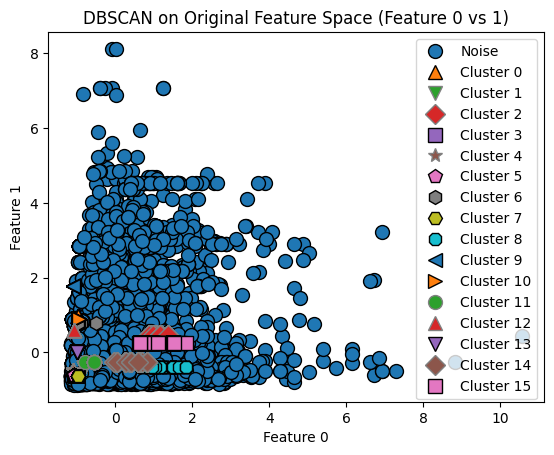

In [109]:
dbscan = DBSCAN(min_samples=50,eps=0.5)
clusters = dbscan.fit_predict(X_train_final)

mglearn.discrete_scatter(X_train_final[:, 0], X_train_final[:, 1], clusters)

plt.title("DBSCAN on Original Feature Space (Feature 0 vs 1)")
plt.legend(labels, loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

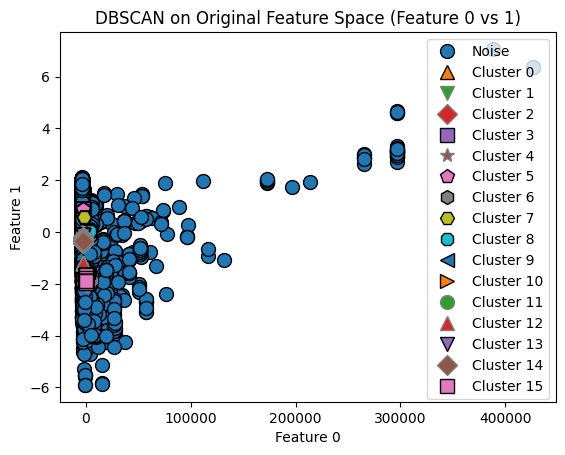

In [110]:

dbscanPCA = DBSCAN(min_samples=50,eps=0.5)
clustersPCA = dbscanPCA.fit_predict(X_train_pca2)

# plot the cluster assignments
mglearn.discrete_scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], clusters)

unique = np.unique(clusters)
labels = [("Noise" if c == -1 else f"Cluster {c}") for c in unique]

plt.legend(labels, loc="best")
plt.title("DBSCAN on Original Feature Space (Feature 0 vs 1)")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


# **Calculate ARI and Silhouette Coefficient**

## **ARI - Original**

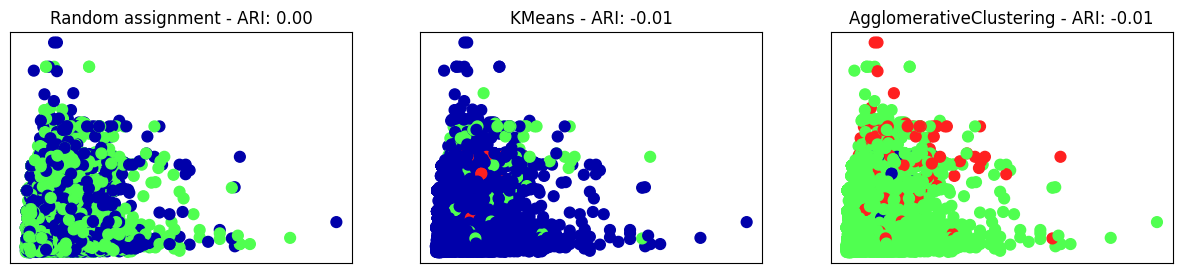

In [111]:
from sklearn.metrics.cluster import adjusted_rand_score
X_train_scaled = X_train_final
fig, axes = plt.subplots(1, 3, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_scaled))

# plot random assignment
axes[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train_scaled)
    ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))


## **ARI - PCA**

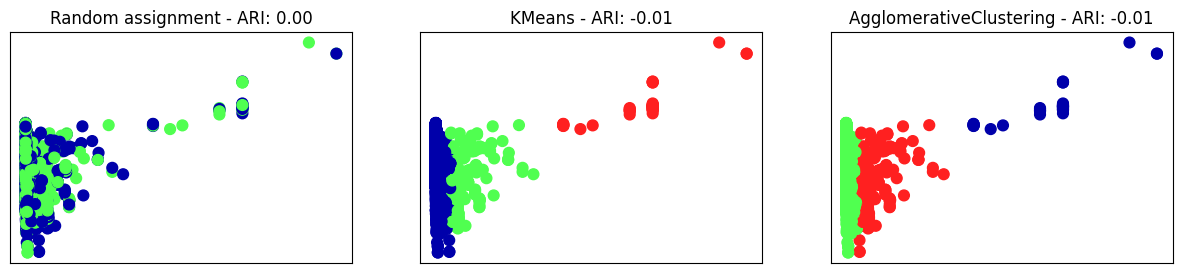

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_pca2))

# plot random assignment
axes[0].scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train_pca2)
    ax.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

## **Silhouette Coefficient - Original**

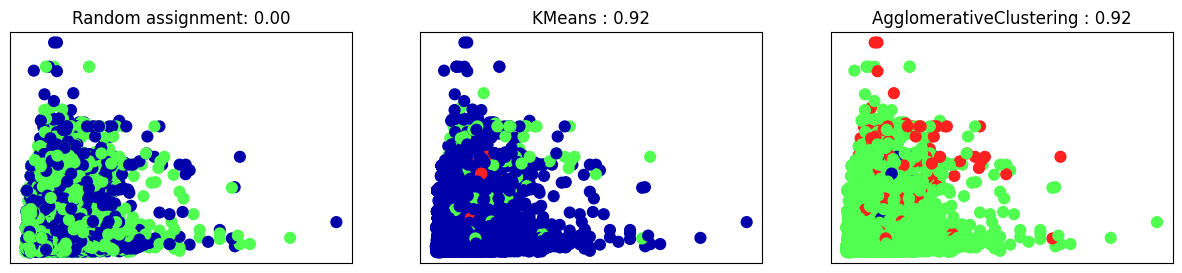

In [113]:
from sklearn.metrics.cluster import silhouette_score
X_train_scaled = X_train_final

fig, axes = plt.subplots(1, 3, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_scaled))

# plot random assignment
axes[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3)]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train_scaled, clusters)))


## **Silhouette Coefficient - PCA**

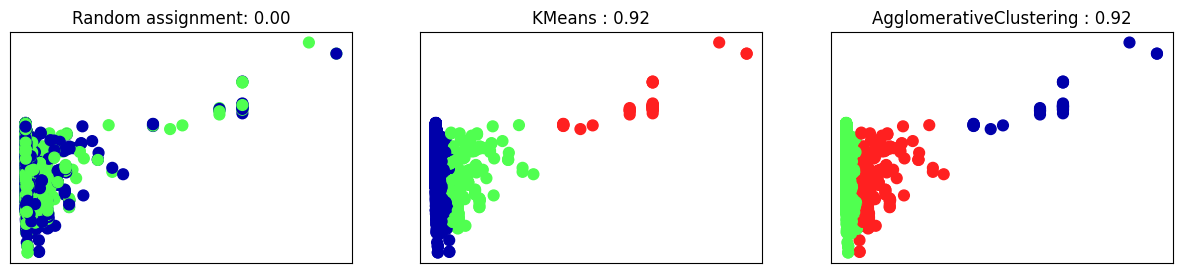

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_pca2, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3)]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_pca2)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train_pca2, clusters)))

# 💡 Bonus: Additional attempt: reduce features for clustering

##For the final clustering experiment, I focused on a reduced set of economically meaningful features: average wage, company size, company age, and industry, and excluding high-cardinality geographic variables that dominated distance calculations in earlier experiments.

In [115]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_cols = ['JOB_AVG_WAGE']
ord_cols = ['COMPANY_SIZE_CAT', 'COMPANY_AGE_CAT']
cat_cols = ['NAICS_DESCRIPTION']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ord', 'passthrough', ord_cols),
        ('cat', OneHotEncoder(sparse_output=False), cat_cols)
    ]
)

X_cluster = preprocessor.fit_transform(X_train)


## K means on original and PSA data


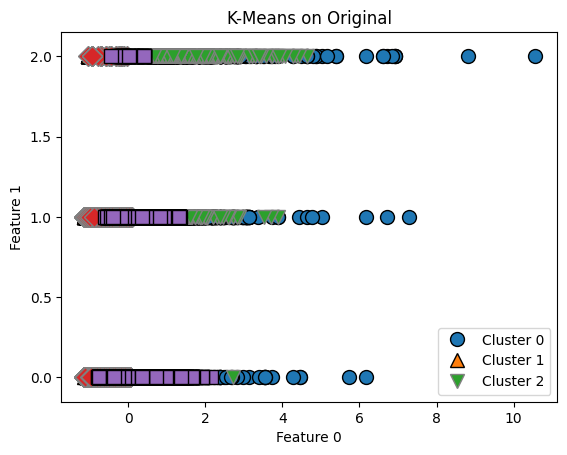

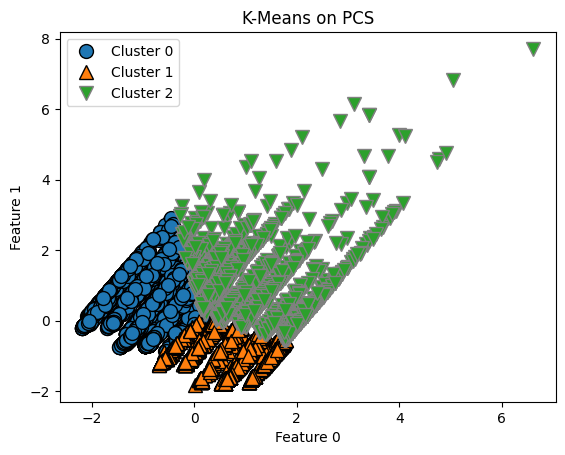

In [133]:
pca_2 = PCA(n_components=2)
X_2d = pca_2.fit_transform(X_cluster)


kmeans_orig = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_orig.fit(X_cluster)

assignments=kmeans_orig.labels_
mglearn.discrete_scatter(
    X_cluster[:, 0],
    X_cluster[:, 1],
    assignments
)
plt.title("K-Means on Original")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.show()


kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_pca.fit(X_2d)

assignments=kmeans_pca.labels_
mglearn.discrete_scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    assignments
)
plt.title("K-Means on PCS")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.show()



## Why K-Means is a poor fit here

**K-Means assumes:**

* clusters are spherical

* clusters have similar variance

* separation is based on Euclidean distance

**My data:**

* has elongated, diagonal structure

* looks more like overlapping distributions

* reflects continuous economic variation, not categories


## Agglomerative single linkage on original


Text(0, 0.5, 'Feature 1')

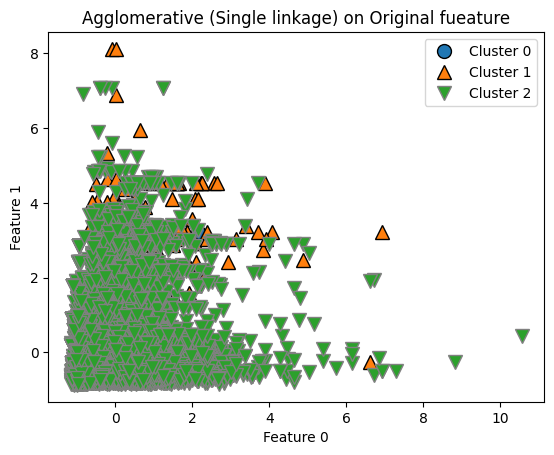

In [140]:
#Original
agg = AgglomerativeClustering(
    n_clusters=3,
    linkage='single'
)
agg.fit(X_train_final)

mglearn.discrete_scatter(X_train_final[:, 0], X_train_final[:, 1], assignment)
plt.title("Agglomerative (Single linkage) on Original fueature")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")


## Agglomerative single linkage on PSA


Text(0, 0.5, 'PC2')

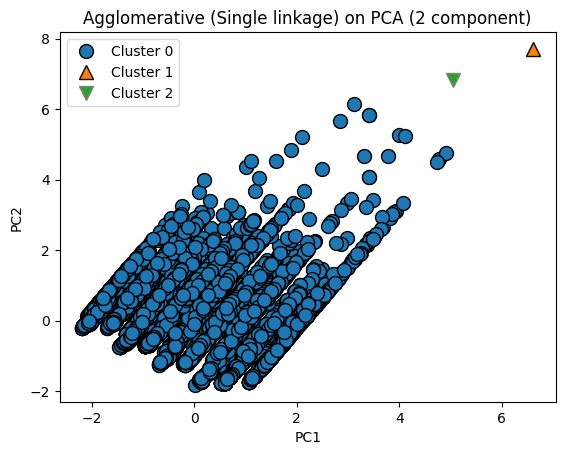

In [143]:

#PCA
agg_single_pca = AgglomerativeClustering(
    n_clusters=3,
    linkage='single'
)
agg_single_pca.fit(X_2d)

assignments=agg_single_pca.labels_
mglearn.discrete_scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    assignments)
plt.title("Agglomerative (Single linkage) on PCA (2 component)")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("PC1")
plt.ylabel("PC2")


In [153]:
#I can see that both cases 0 is dominating cluster

agg_single=agg.fit(X_train_final)
labels_orig = agg_single.labels_

agg_single_psa=agg.fit(X_2d)
labels_psa = agg_single_psa.labels_

print(dict(zip(*np.unique(labels_orig, return_counts=True))))
print(dict(zip(*np.unique(labels_psa, return_counts=True))))


{0: 12334, 1: 3, 2: 29}
{0: 12364, 1: 1, 2: 1}



##Why Agglomerative Clustering (Single Linkage) also failed
**Single linkage assumes:**

* clusters are defined by local connectivity (nearest neighbors)

* clusters can be arbitrarily shaped

* separation exists when there are gaps in distance between groups

**My data:**

* forms a continuous, smoothly connected structure

* has no clear gaps between observations

* exhibits a gradual economic gradient rather than isolated groups


**Discovery:**

Rather than revealing meaningful group structure, single-linkage agglomerative clustering highlights the high connectivity of the data, indicating that the observations lie on a continuous spectrum rather than forming distinct clusters.